# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
# seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

40



# Data preparation

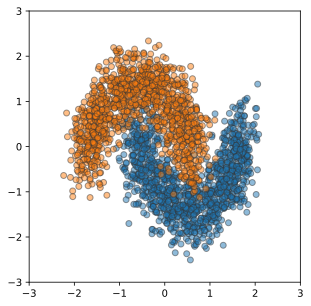

In [2]:
data_noise = 0.2
plotlim = [-3, 3]
subfolder = 'traj_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed, label = 'vector')


In [3]:
for x_batch, y_batch in dataloader:
    print(x_batch, y_batch)
    print(y_batch[0:20].size())
    
    print(len(y_batch.shape) > 1)
    break

tensor([[-1.4786,  0.3549],
        [-0.8063,  0.9795],
        [-0.1840, -1.0830],
        [ 0.6517, -0.6564],
        [-0.4205, -0.9936],
        [ 0.5772, -1.5373],
        [-1.0092,  1.0723],
        [ 0.2938, -0.9572],
        [-1.5980,  0.7997],
        [ 0.2263,  0.2168],
        [ 1.5942, -0.0122],
        [ 0.0881,  0.0751],
        [-0.2950, -1.0214],
        [-1.3807,  1.1293],
        [ 0.6334, -1.2870],
        [ 1.1459, -1.4940],
        [ 0.0137, -1.1825],
        [-0.5645,  1.8015],
        [ 1.4410, -0.6285],
        [-0.8694,  1.9742],
        [-0.1276, -1.6460],
        [-0.1853,  0.8483],
        [ 1.2564, -0.9715],
        [-0.9294,  1.4209],
        [-1.4436,  1.3522],
        [-0.2696, -1.8327],
        [ 0.0731, -0.6461],
        [ 0.5729,  0.9318],
        [-1.6619,  0.9564],
        [-1.4952,  0.7270],
        [-0.5628,  0.3572],
        [-0.5460,  1.3284],
        [ 0.5157, -1.7495],
        [ 0.3928,  0.0488],
        [-0.7120,  1.3777],
        [-0.9978,  2

## Model dynamics

In [4]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 20
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = False
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside


## Training and generating level sets

In [5]:

num_epochs = 80 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [6]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 2.155

Iteration 10/38
Loss: 2.010

Iteration 20/38
Loss: 1.729

Iteration 30/38
Loss: 1.565
Epoch 1: 1.787

Iteration 0/38
Loss: 1.606

Iteration 10/38
Loss: 1.522

Iteration 20/38
Loss: 1.391

Iteration 30/38
Loss: 1.604
Epoch 2: 1.503

Iteration 0/38
Loss: 1.414

Iteration 10/38
Loss: 1.350

Iteration 20/38
Loss: 1.400

Iteration 30/38
Loss: 1.392
Epoch 3: 1.386

Iteration 0/38
Loss: 1.384

Iteration 10/38
Loss: 1.412

Iteration 20/38
Loss: 1.493

Iteration 30/38
Loss: 1.407
Epoch 4: 1.283

Iteration 0/38
Loss: 1.236

Iteration 10/38
Loss: 0.916

Iteration 20/38
Loss: 1.258

Iteration 30/38
Loss: 1.318
Epoch 5: 1.193

Iteration 0/38
Loss: 1.106

Iteration 10/38
Loss: 1.109

Iteration 20/38
Loss: 1.254

Iteration 30/38
Loss: 0.978
Epoch 6: 1.131

Iteration 0/38
Loss: 1.047

Iteration 10/38
Loss: 1.044

Iteration 20/38
Loss: 1.130

Iteration 30/38
Loss: 1.321
Epoch 7: 1.084

Iteration 0/38
Loss: 1.141

Iteration 10/38
Loss: 0.886

Iteration 20/38
Loss: 0.869

Ite

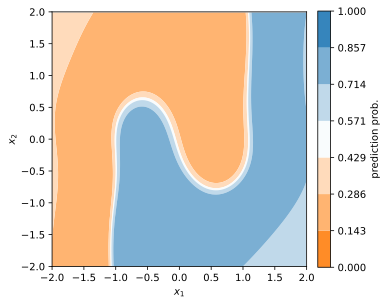

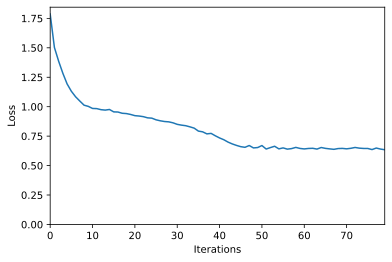

In [7]:
from plots.plots import classification_levelsets
classification_levelsets(anode)
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

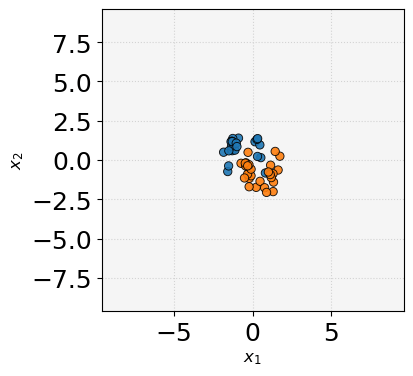

In [8]:
from plots.gifs import trajectory_gif
from IPython.display import Image

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
display(traj)

In [9]:
   
w = anode.linear_layer.weight
b = anode.linear_layer.bias

print(w)
print(b)

rnode.linear_layer.weight = w
rnode.linear_layer.bias = b

rnode.linear_layer.requires_grad =  False

Parameter containing:
tensor([[ 0.9953,  0.7460],
        [ 0.1671, -0.2706]], requires_grad=True)
Parameter containing:
tensor([-0.2606, -0.2665], requires_grad=True)


In [10]:
trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, db_type='l2') 
trainer_rnode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 1.868

Iteration 10/38
Loss: 1.629

Iteration 20/38
Loss: 1.429

Iteration 30/38
Loss: 1.339
Epoch 1: 1.573

Iteration 0/38
Loss: 1.389

Iteration 10/38
Loss: 1.180

Iteration 20/38
Loss: 1.000

Iteration 30/38
Loss: 1.401
Epoch 2: 1.206

Iteration 0/38
Loss: 1.219

Iteration 10/38
Loss: 1.108

Iteration 20/38
Loss: 1.007

Iteration 30/38
Loss: 1.028
Epoch 3: 1.114

Iteration 0/38
Loss: 1.089

Iteration 10/38
Loss: 0.872

Iteration 20/38
Loss: 0.999

Iteration 30/38
Loss: 1.150
Epoch 4: 1.037

Iteration 0/38
Loss: 0.837

Iteration 10/38
Loss: 1.049

Iteration 20/38
Loss: 1.028

Iteration 30/38
Loss: 0.879
Epoch 5: 0.971

Iteration 0/38
Loss: 1.079

Iteration 10/38
Loss: 0.818

Iteration 20/38
Loss: 1.010

Iteration 30/38
Loss: 1.030
Epoch 6: 0.933

Iteration 0/38
Loss: 0.934

Iteration 10/38
Loss: 0.896

Iteration 20/38
Loss: 0.704

Iteration 30/38
Loss: 0.923
Epoch 7: 0.895

Iteration 0/38
Loss: 1.104

Iteration 10/38
Loss: 0.837

Iteration 20/38
Loss: 0.770

Ite

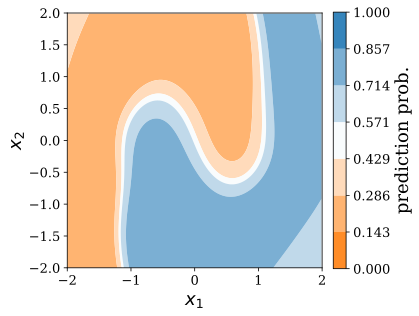

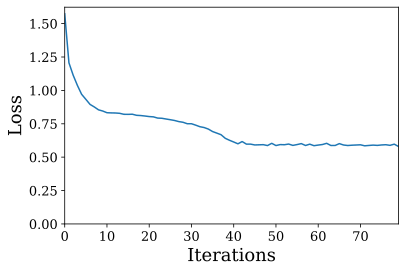

In [11]:
from plots.plots import classification_levelsets
classification_levelsets(rnode)
plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

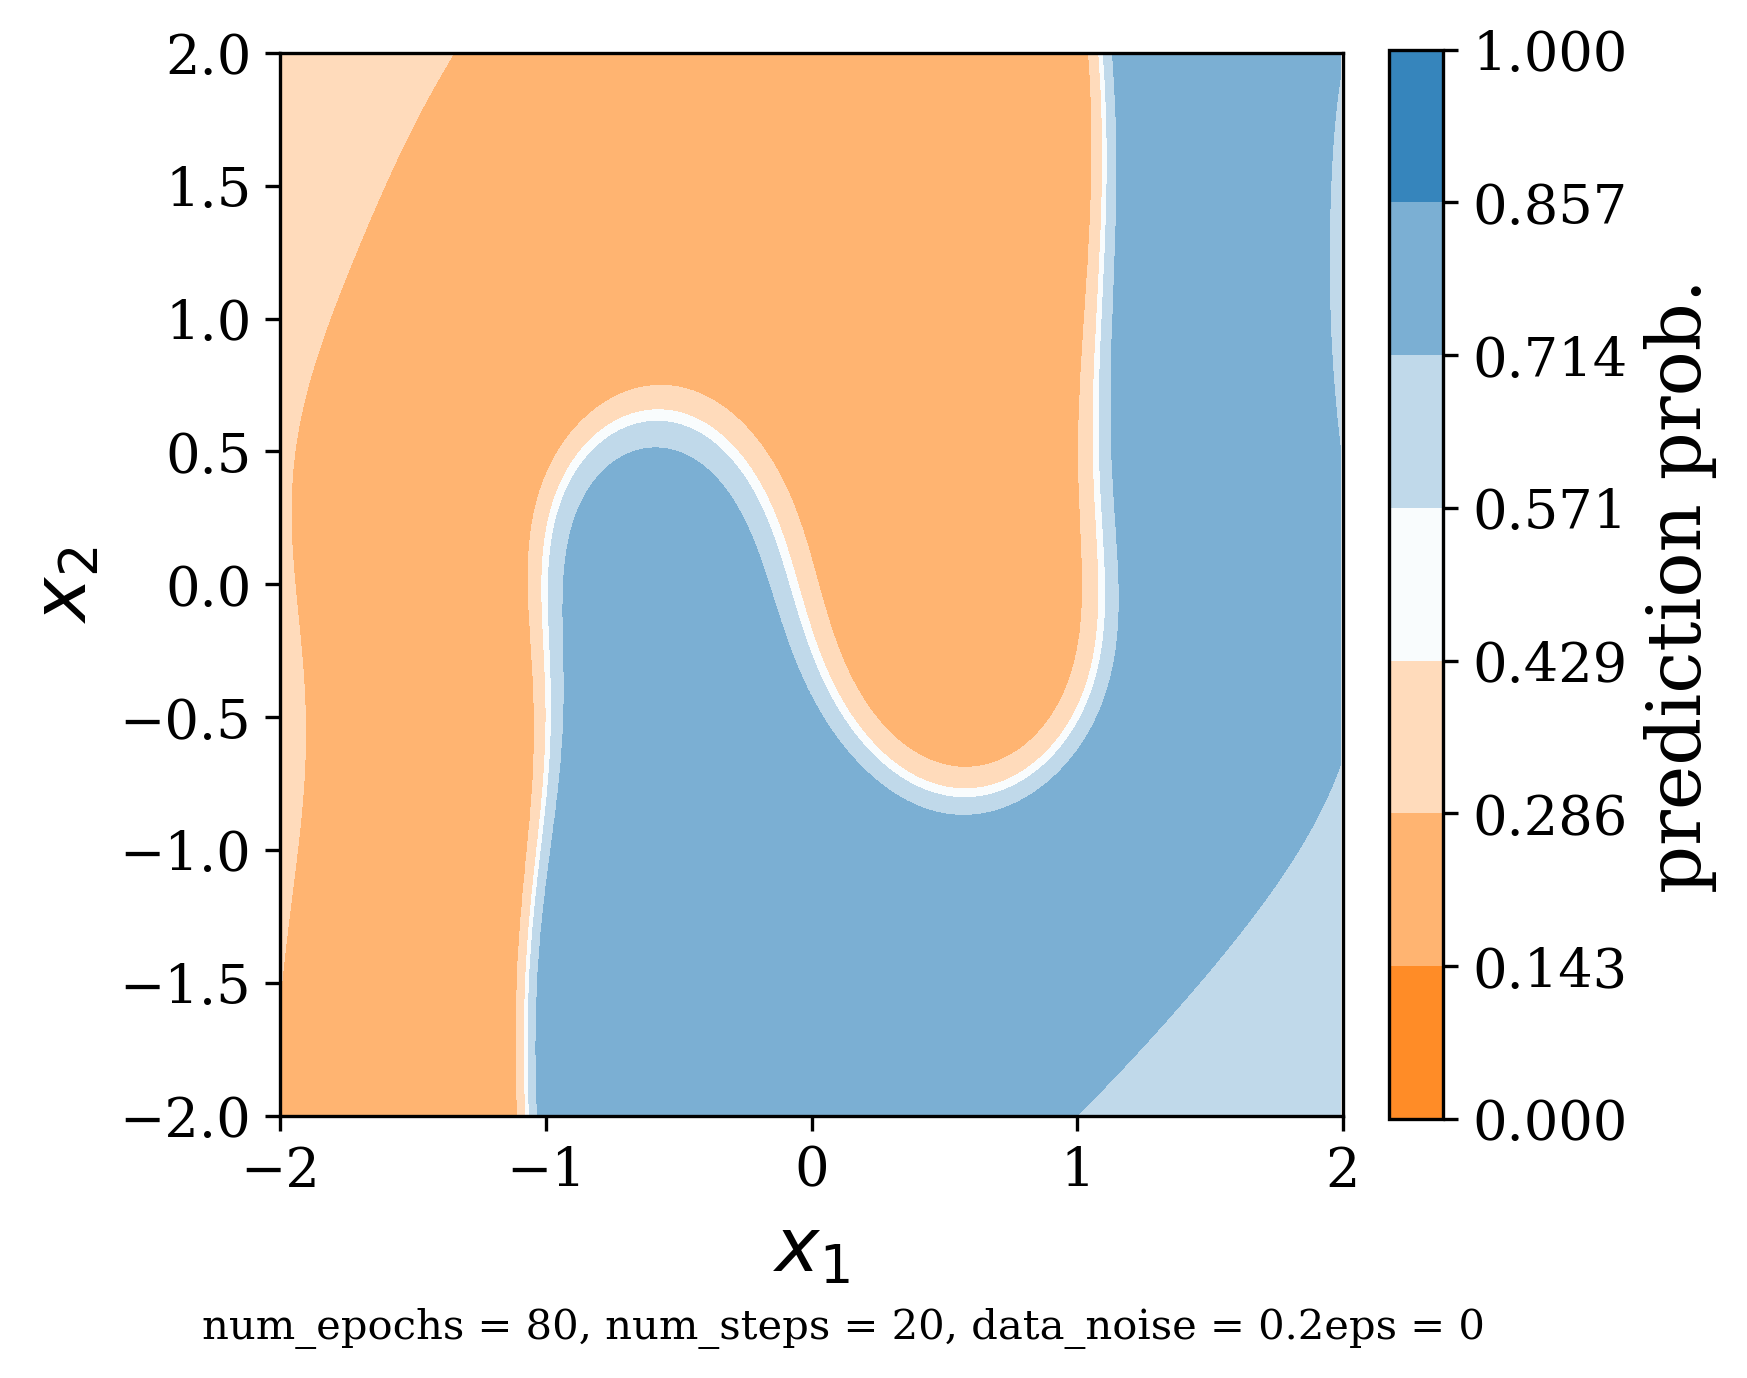

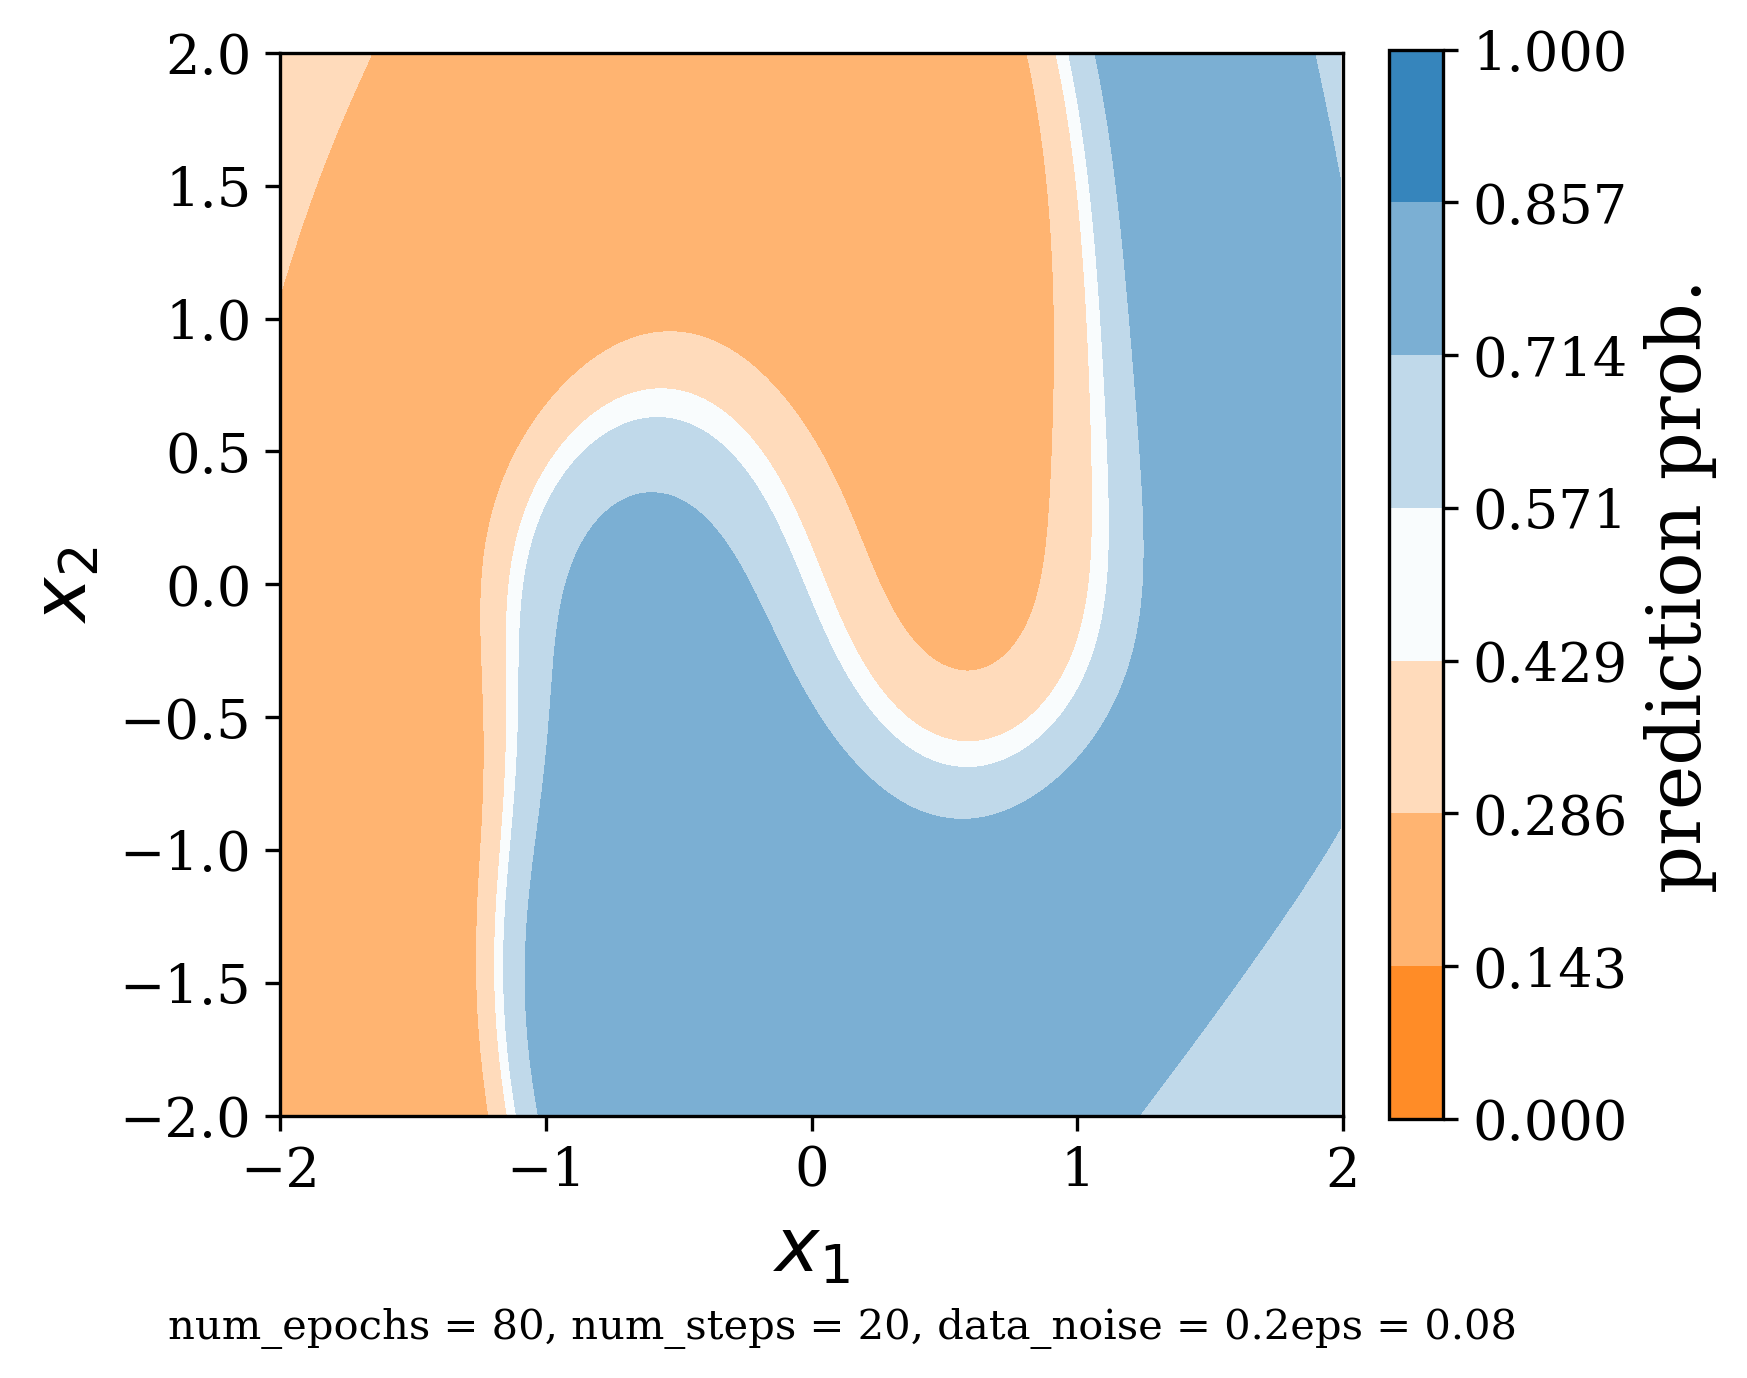

In [44]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
footnote = f'{num_epochs = }, {num_steps = }, {data_noise = }'
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base, footnote = footnote + 'eps = 0')
classification_levelsets(rnode, fig_name_base + '_rob', footnote = footnote + f'{eps = }')
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = fig_name_base + '_rob.png', width = 400)

display(img1,img2)

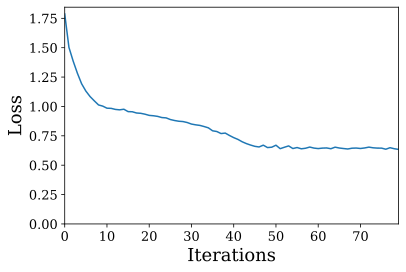

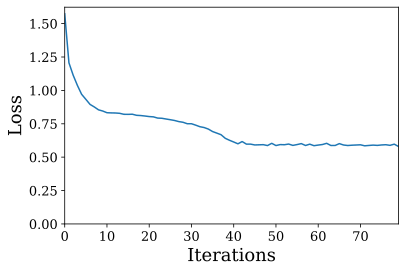

In [13]:
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [14]:
for X_viz, y_viz in dataloader_viz:
    X_viz = X_viz[0:5]
    break

trajectories = anode.flow.trajectory(X_viz, 10).detach()
print(X_viz)
print(trajectories.size()) #time is in the first coordinate




tensor([[-1.7282, -0.2508],
        [ 0.1623,  0.4649],
        [ 0.0310, -0.3768],
        [ 1.4952, -1.1595],
        [ 1.5320, -0.9923]])
torch.Size([10, 5, 2])


## Lyapunov exponent computation

In [15]:
'''
input: two trajectories x(t), y(t) where each has size (x_dim,len_t)
output: maximum lyapunov exponent for each time t, size (1,len_t)'''
def le(x,y,t):
    d = x - y
    d = torch.linalg.norm(x - y, dim = 0)
    # print(f'{d.shape = }')
    d = d/d[0]
    d = np.log(d)
    

    d = d/t
    return d



'''
Compute the maximum Lyapunov exponent with initial value tolerance eps
input: 
trajectories of size (x_amount,x_amount,x_dim,time_dim)
each trajectory has initial value x_0 = traj[i,j,:,0]

output:
MLE for each trajectory as averaged LE for all initial values that is eps close to the initial value
output size (x_amount,x_amount,t_dim)
'''
def MLE(traj, t, eps = 0.1):
    x_amount = traj.size(0)
    x_amount, y_amount, x_dim, t_dim = traj.shape
    le_val = torch.zeros((x_amount, y_amount, t_dim)) 
    print(f'{le_val.shape = }')
    for i in range(x_amount):
        for j in range(y_amount):
            count = 0
            for i_comp in range(x_amount):
                for j_comp in range(y_amount):
                    if (torch.norm(traj[i,j,:,0] - traj[i_comp,j_comp,:,0]) < eps and not(i == i_comp and j == j_comp)):
                        count += 1
                        le_val[i,j] += le(traj[i,j,:,:],traj[i_comp,j_comp,:,:],t)
                        print('avg le update with count ',count,' and value ',le_val[i,j,-1])
            if count > 1:
                le_val[i,j,:] = le_val[i,j,:]/count
    return le_val



In [16]:

x_amount = 70
eps = 0.08
t = torch.linspace(0,T,2) #only take initial and final time for MLE


x = torch.linspace(-2,2,x_amount)
y = torch.linspace(-2,2,x_amount)
X, Y = torch.meshgrid(x, y)

inputs = torch.stack([X,Y], dim=-1)
print(f'{inputs.size() = }')
# print(inputs)

trajectories = anode.flow.trajectory(inputs, num_steps).detach()
t_indices = torch.tensor([0,-1])

trajectories = trajectories[t_indices] #only take the initial and final time of the trajectory
print('shape of trajectories of grid', trajectories.shape) #MLE works with the time in the last dimension
trajectories = trajectories.permute(1,2,3,0)
print('shape of permuted traj of grid', trajectories.shape) #this fits with the MLE function

output = MLE(trajectories,t,eps)
print(output)
output = output[:,:,-1] #reduce to last time instance T



inputs.size() = torch.Size([70, 70, 2])
shape of trajectories of grid torch.Size([2, 70, 70, 2])
shape of permuted traj of grid torch.Size([70, 70, 2, 2])
le_val.shape = torch.Size([70, 70, 2])
avg le update with count  1  and value  tensor(-0.0759)
avg le update with count  2  and value  tensor(-0.0122)
avg le update with count  1  and value  tensor(-0.0759)
avg le update with count  2  and value  tensor(-0.1570)
avg le update with count  3  and value  tensor(-0.0938)
avg le update with count  1  and value  tensor(-0.0811)
avg le update with count  2  and value  tensor(-0.1663)
avg le update with count  3  and value  tensor(-0.1036)
avg le update with count  1  and value  tensor(-0.0852)
avg le update with count  2  and value  tensor(-0.1728)
avg le update with count  3  and value  tensor(-0.1107)
avg le update with count  1  and value  tensor(-0.0876)
avg le update with count  2  and value  tensor(-0.1757)
avg le update with count  3  and value  tensor(-0.1142)
avg le update with cou

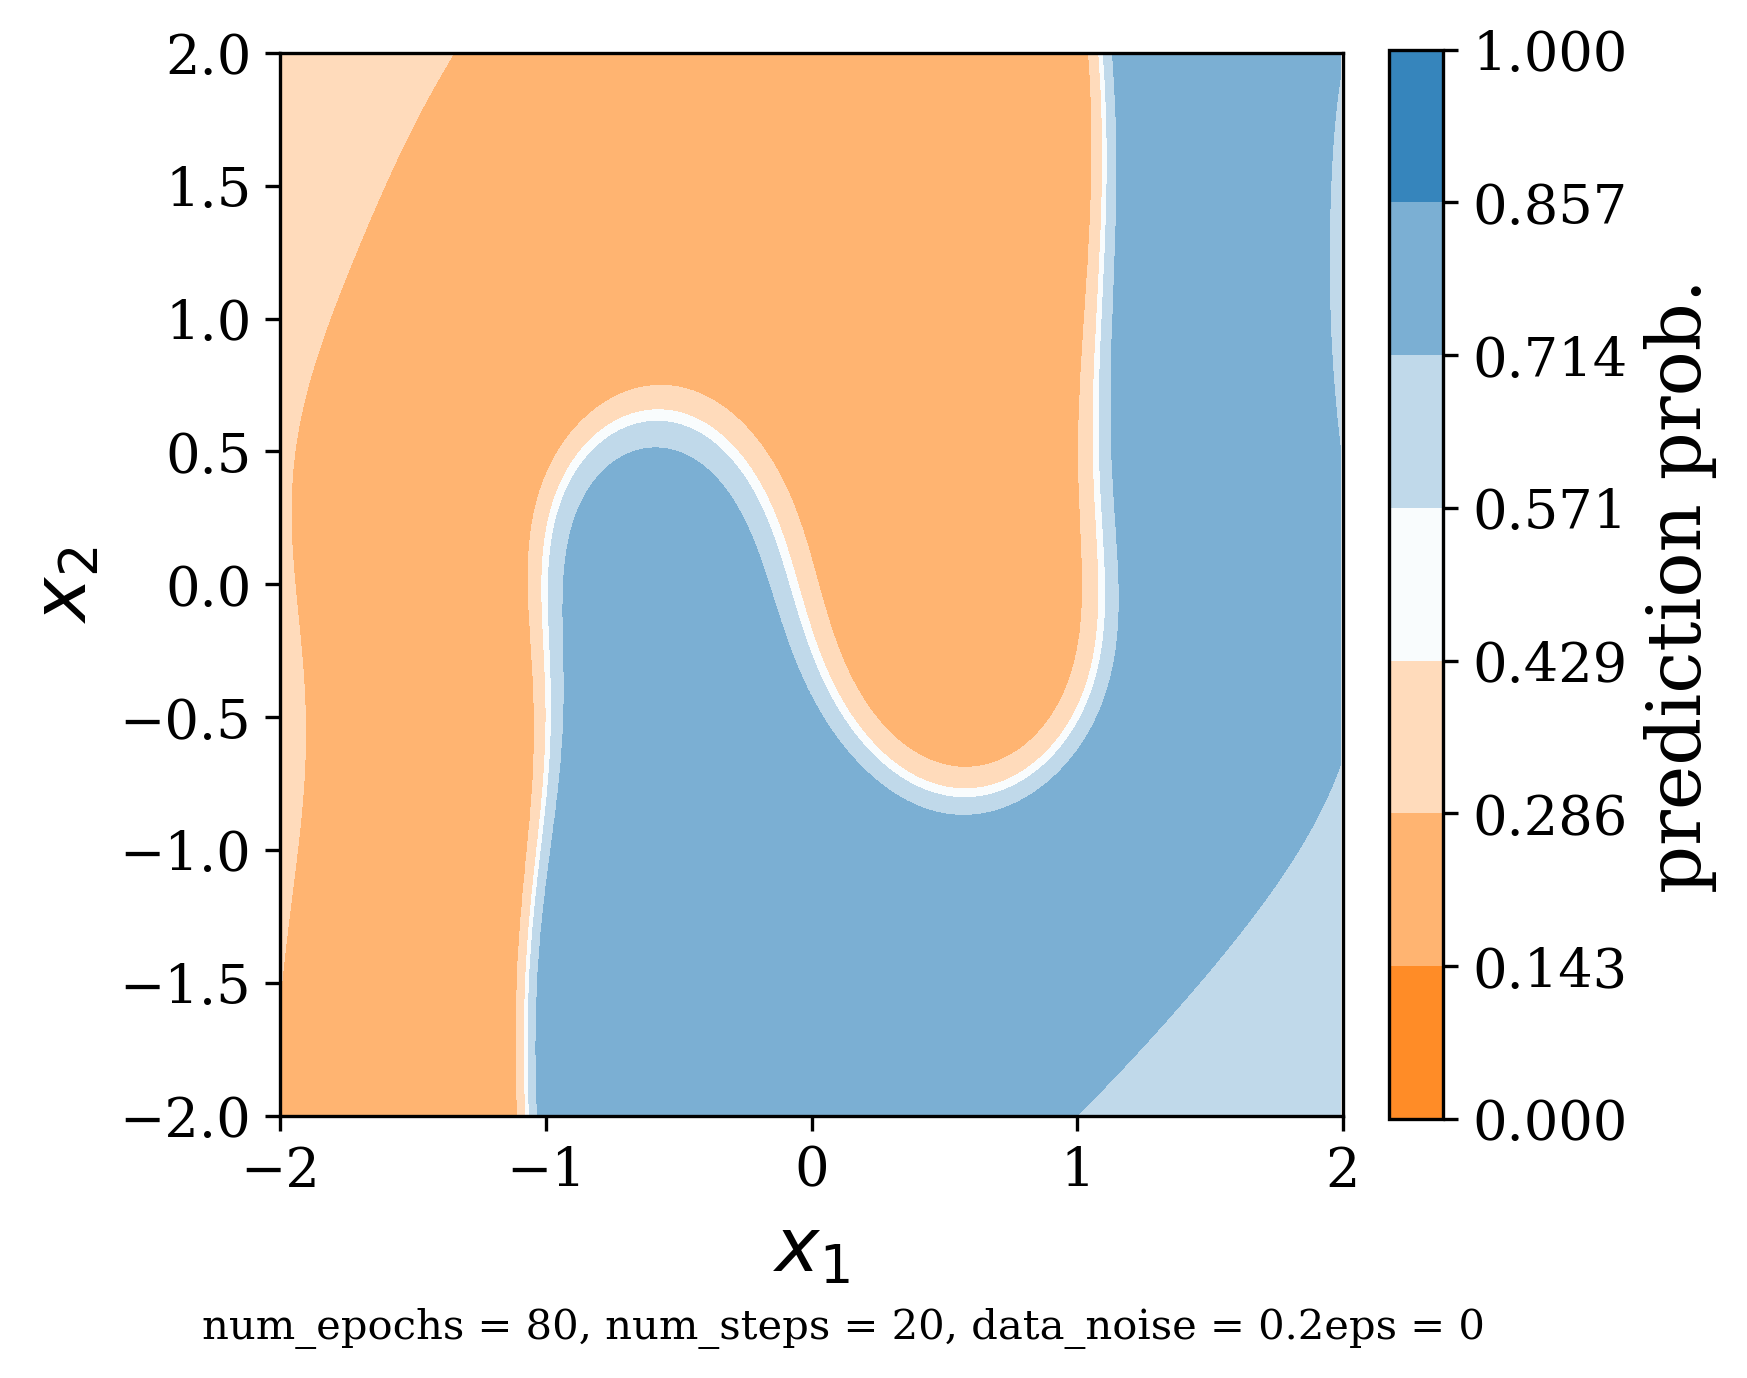

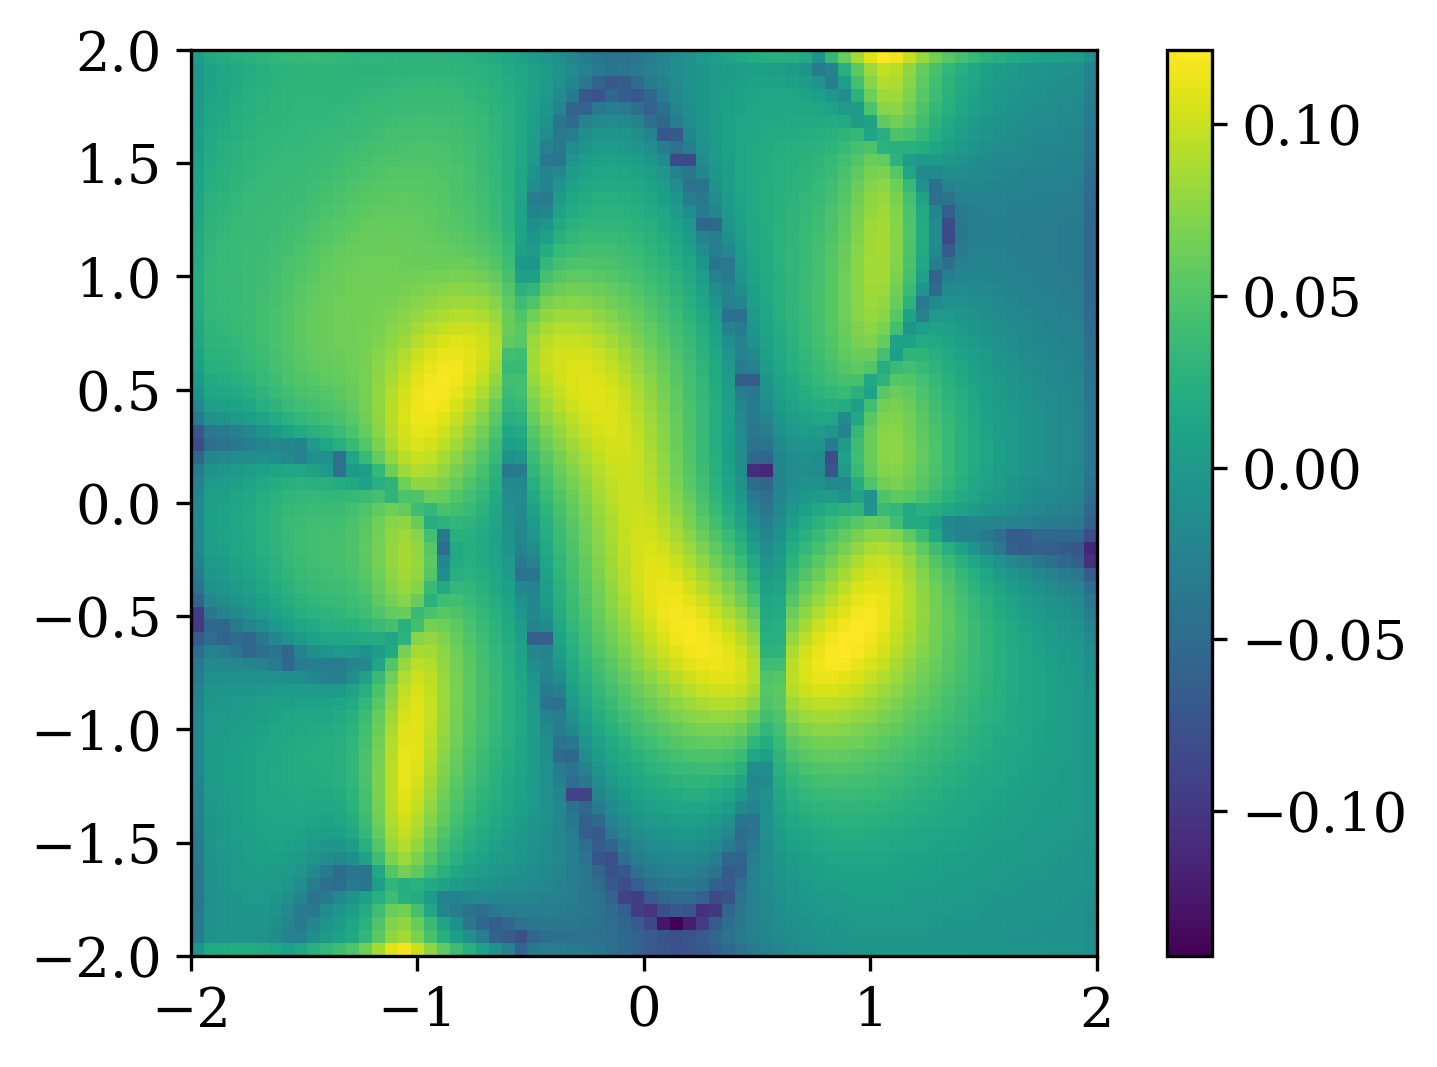

In [17]:
# Create heatmap using imshow
anodeimg = plt.imshow(np.rot90(output), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig('MLE.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = 'MLE.png', width = 400)

display(img1,img2)

In [18]:
rtrajectories = rnode.flow.trajectory(inputs, num_steps).detach()
t_indices = torch.tensor([0,-1])


rtrajectories = rtrajectories[t_indices] #only take the initial and final time of the trajectory
print('shape of trajectories of grid', trajectories.shape) #MLE works with the time in the last dimension
rtrajectories = rtrajectories.permute(1,2,3,0)
print('shape of permuted traj of grid', trajectories.shape) #this fits with the MLE function




routput = MLE(rtrajectories,t,eps)
print(routput)
routput = routput[:,:,-1] #reduce to last time instance T


shape of trajectories of grid torch.Size([70, 70, 2, 2])
shape of permuted traj of grid torch.Size([70, 70, 2, 2])
le_val.shape = torch.Size([70, 70, 2])
avg le update with count  1  and value  tensor(-0.0703)
avg le update with count  2  and value  tensor(-0.0056)
avg le update with count  1  and value  tensor(-0.0703)
avg le update with count  2  and value  tensor(-0.1498)
avg le update with count  3  and value  tensor(-0.0849)
avg le update with count  1  and value  tensor(-0.0795)
avg le update with count  2  and value  tensor(-0.1711)
avg le update with count  3  and value  tensor(-0.1059)
avg le update with count  1  and value  tensor(-0.0916)
avg le update with count  2  and value  tensor(-0.1998)
avg le update with count  3  and value  tensor(-0.1343)
avg le update with count  1  and value  tensor(-0.1082)
avg le update with count  2  and value  tensor(-0.2384)
avg le update with count  3  and value  tensor(-0.1727)
avg le update with count  1  and value  tensor(-0.1302)
avg le

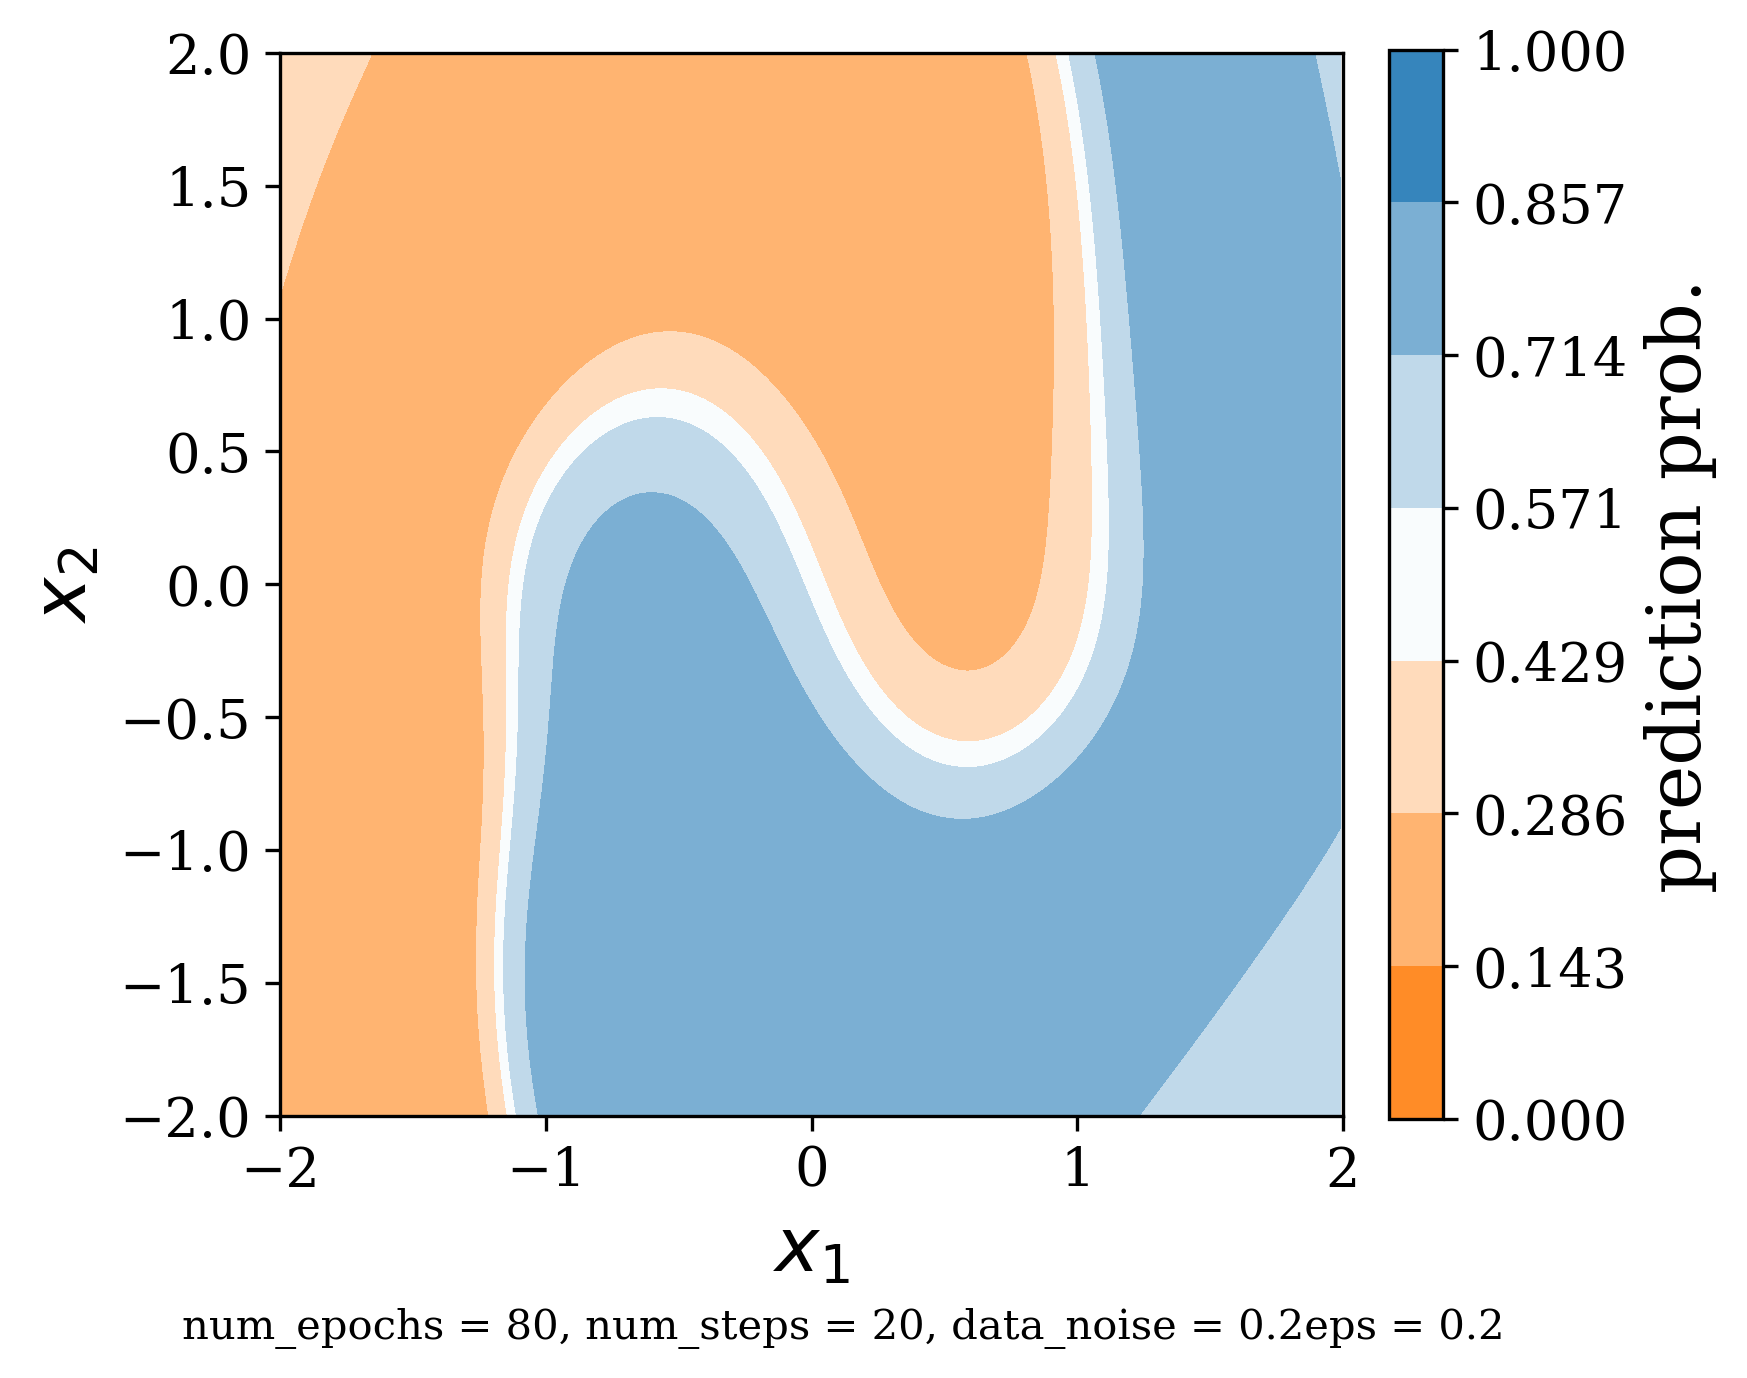

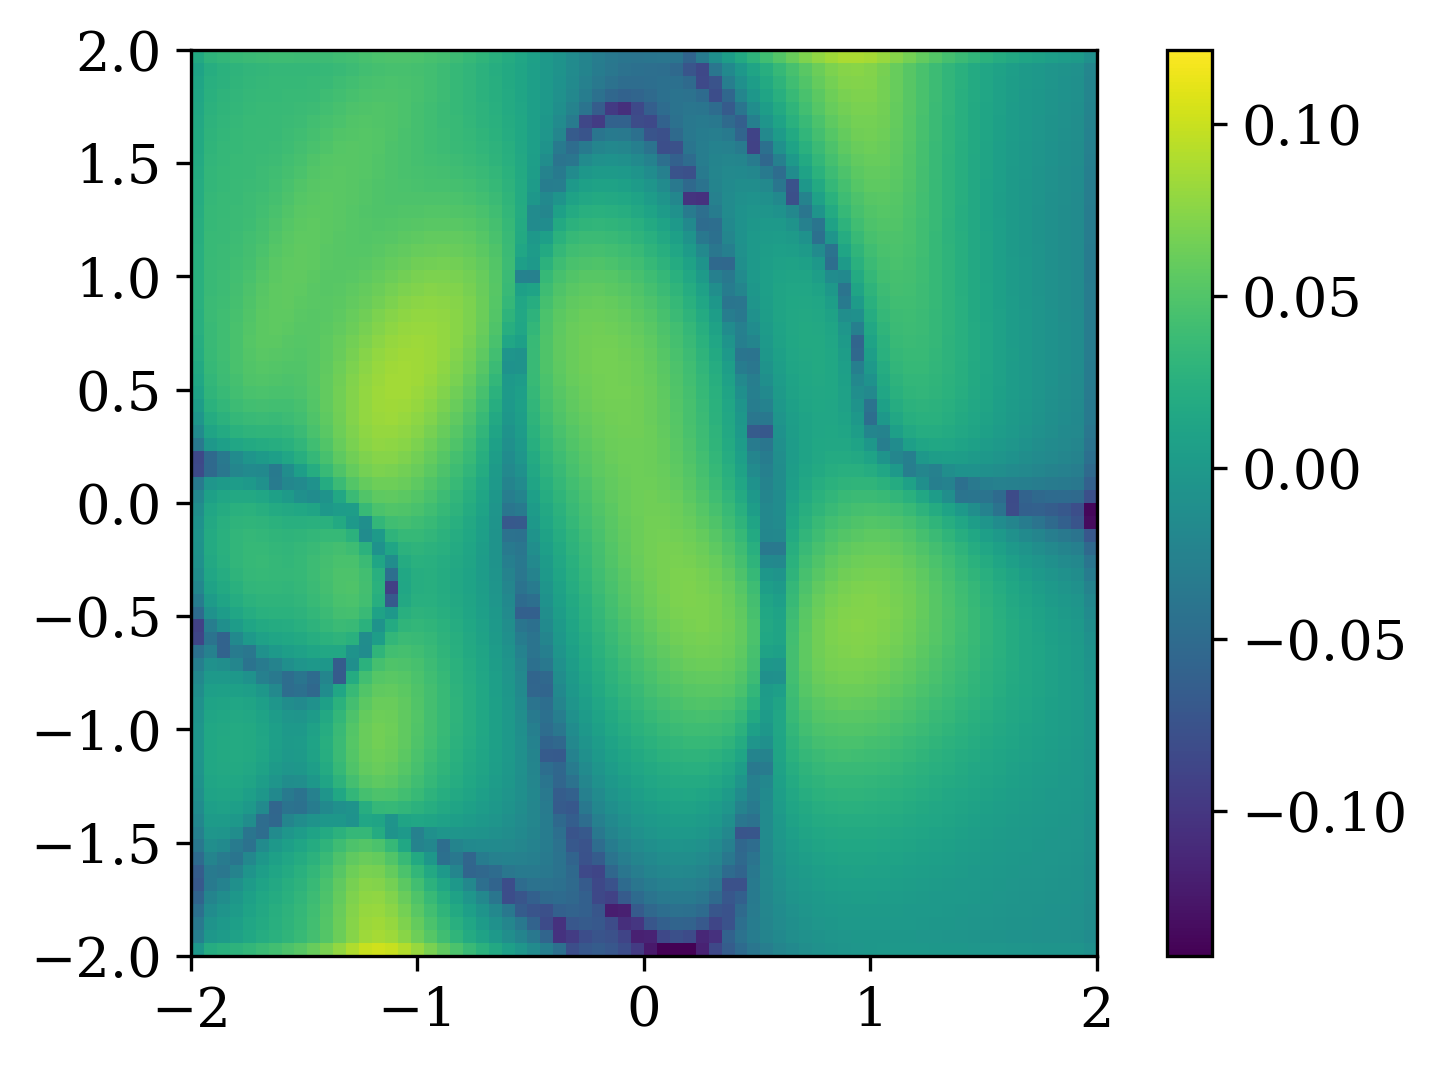

In [19]:
# Create heatmap using imshow

plt.imshow(np.rot90(routput), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
plt.clim(vmin,vmax)
plt.colorbar()  # Show color scale
plt.savefig('MLE_rob.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(filename = fig_name_base + '_rob' + '.png', width = 400)
img2 = Image(filename = 'MLE_rob.png', width = 400)

display(img1,img2)

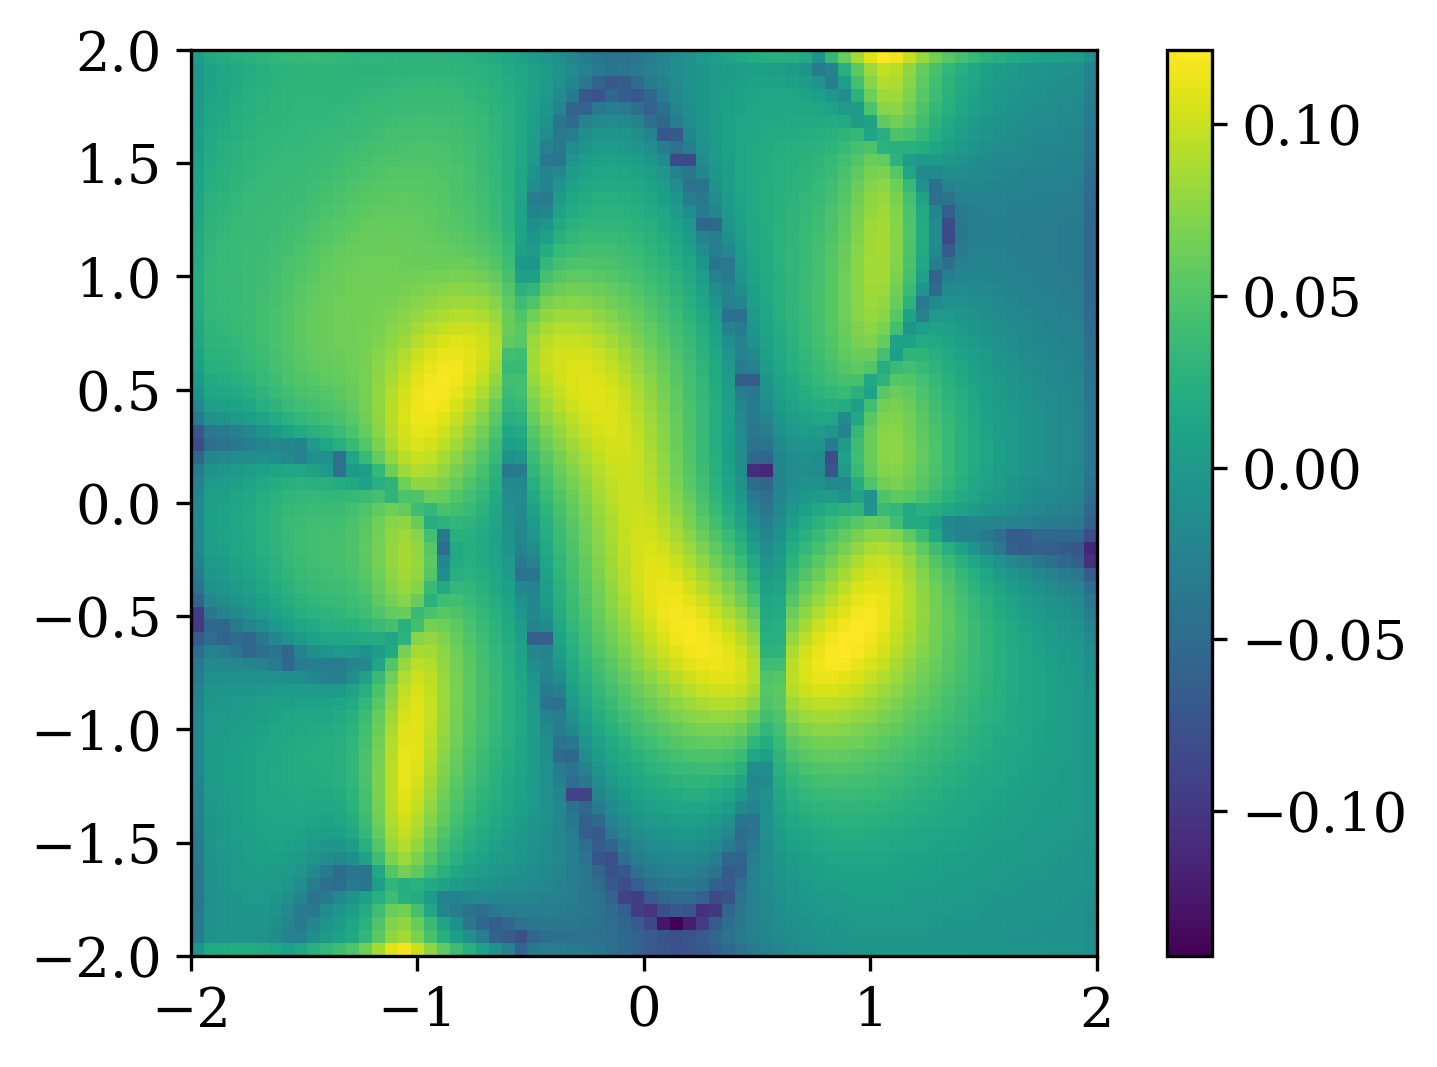

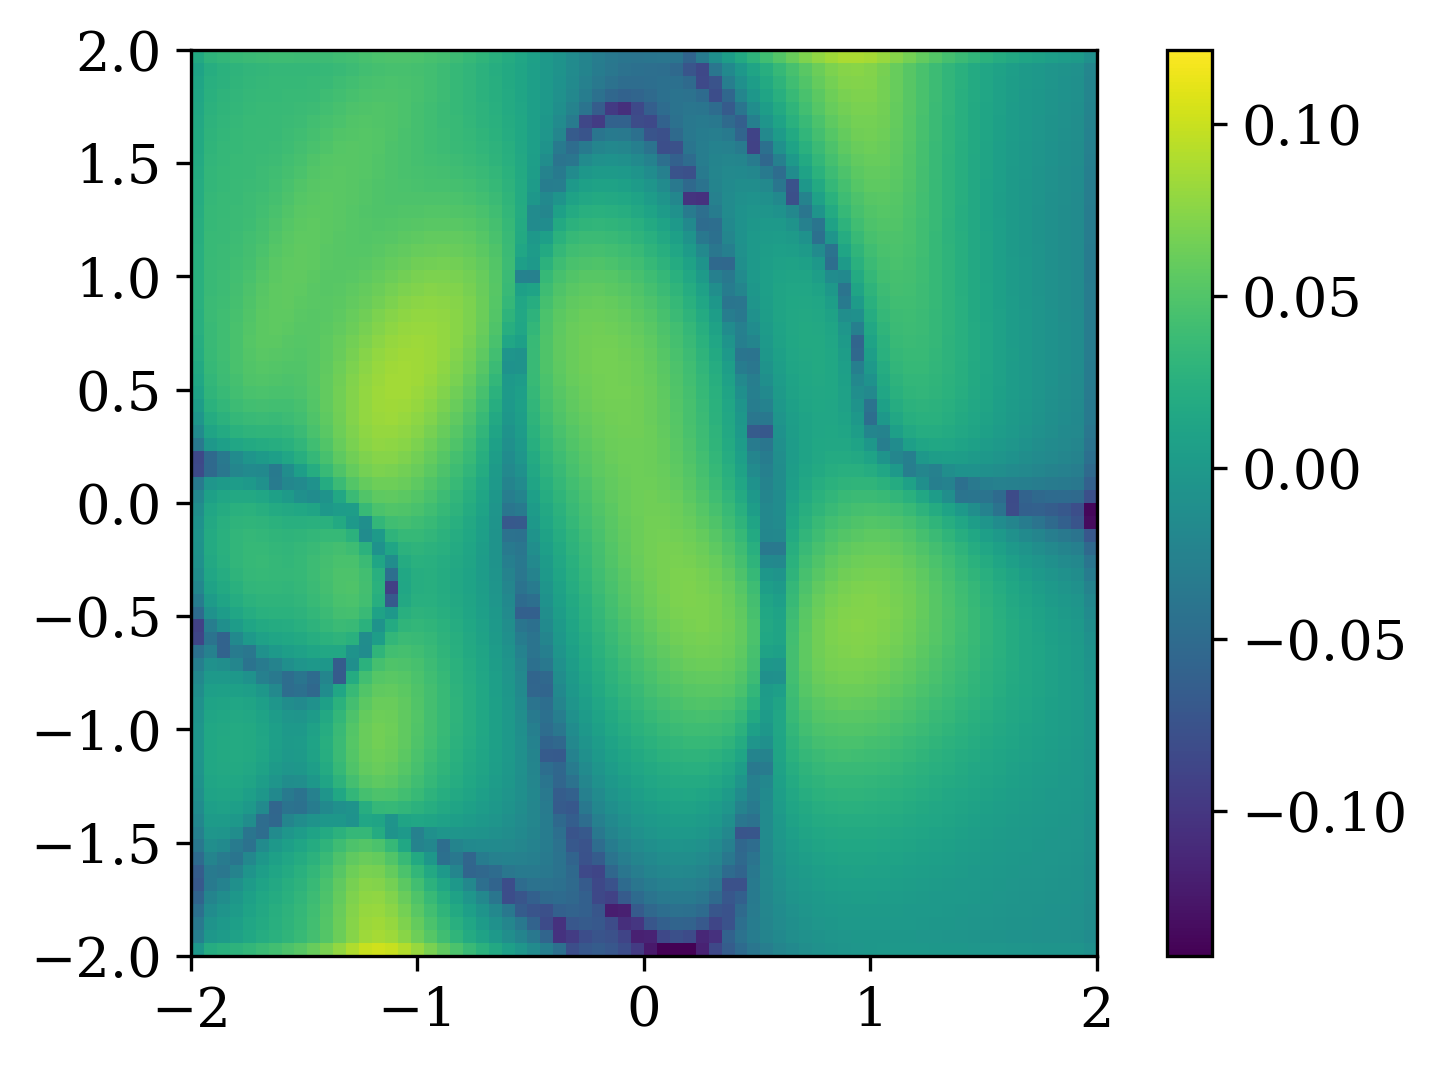

In [20]:
# img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = 'MLE.png', width = 400)
# img3 = Image(filename = fig_name_base + '_rob' + '.png', width = 400)
img4 = Image(filename = 'MLE_rob.png', width = 400)

display(img2,img4)

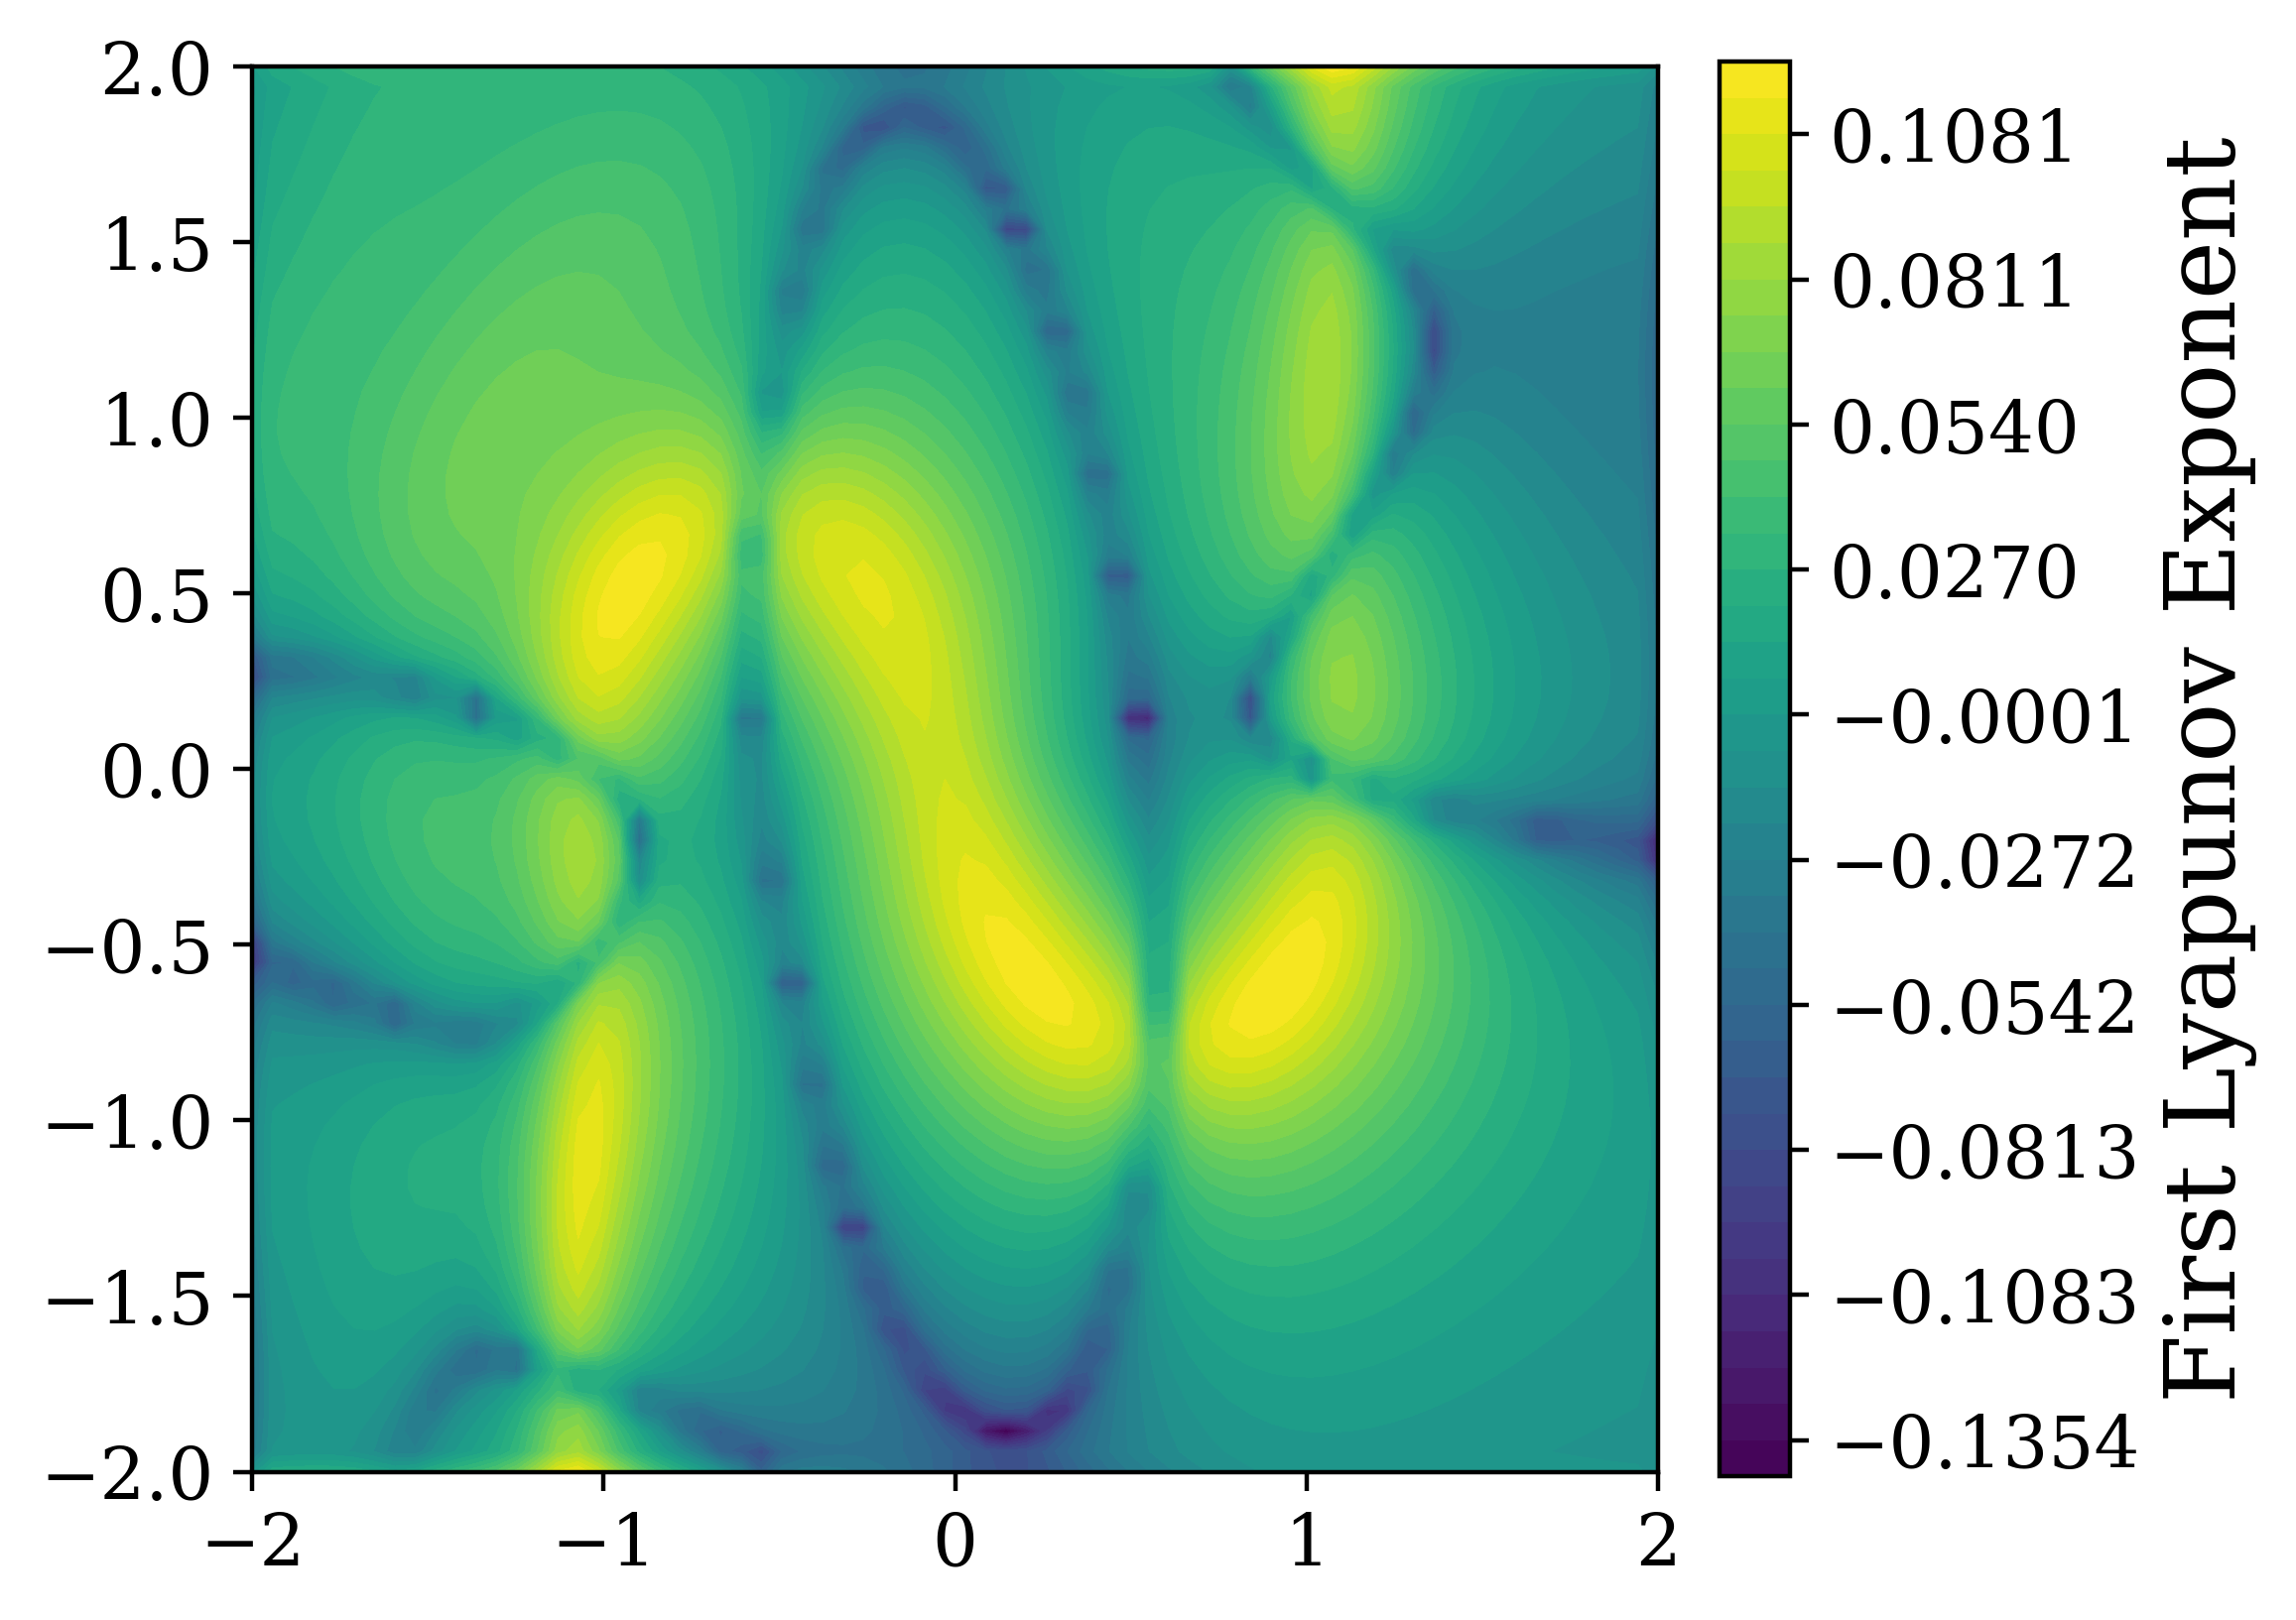

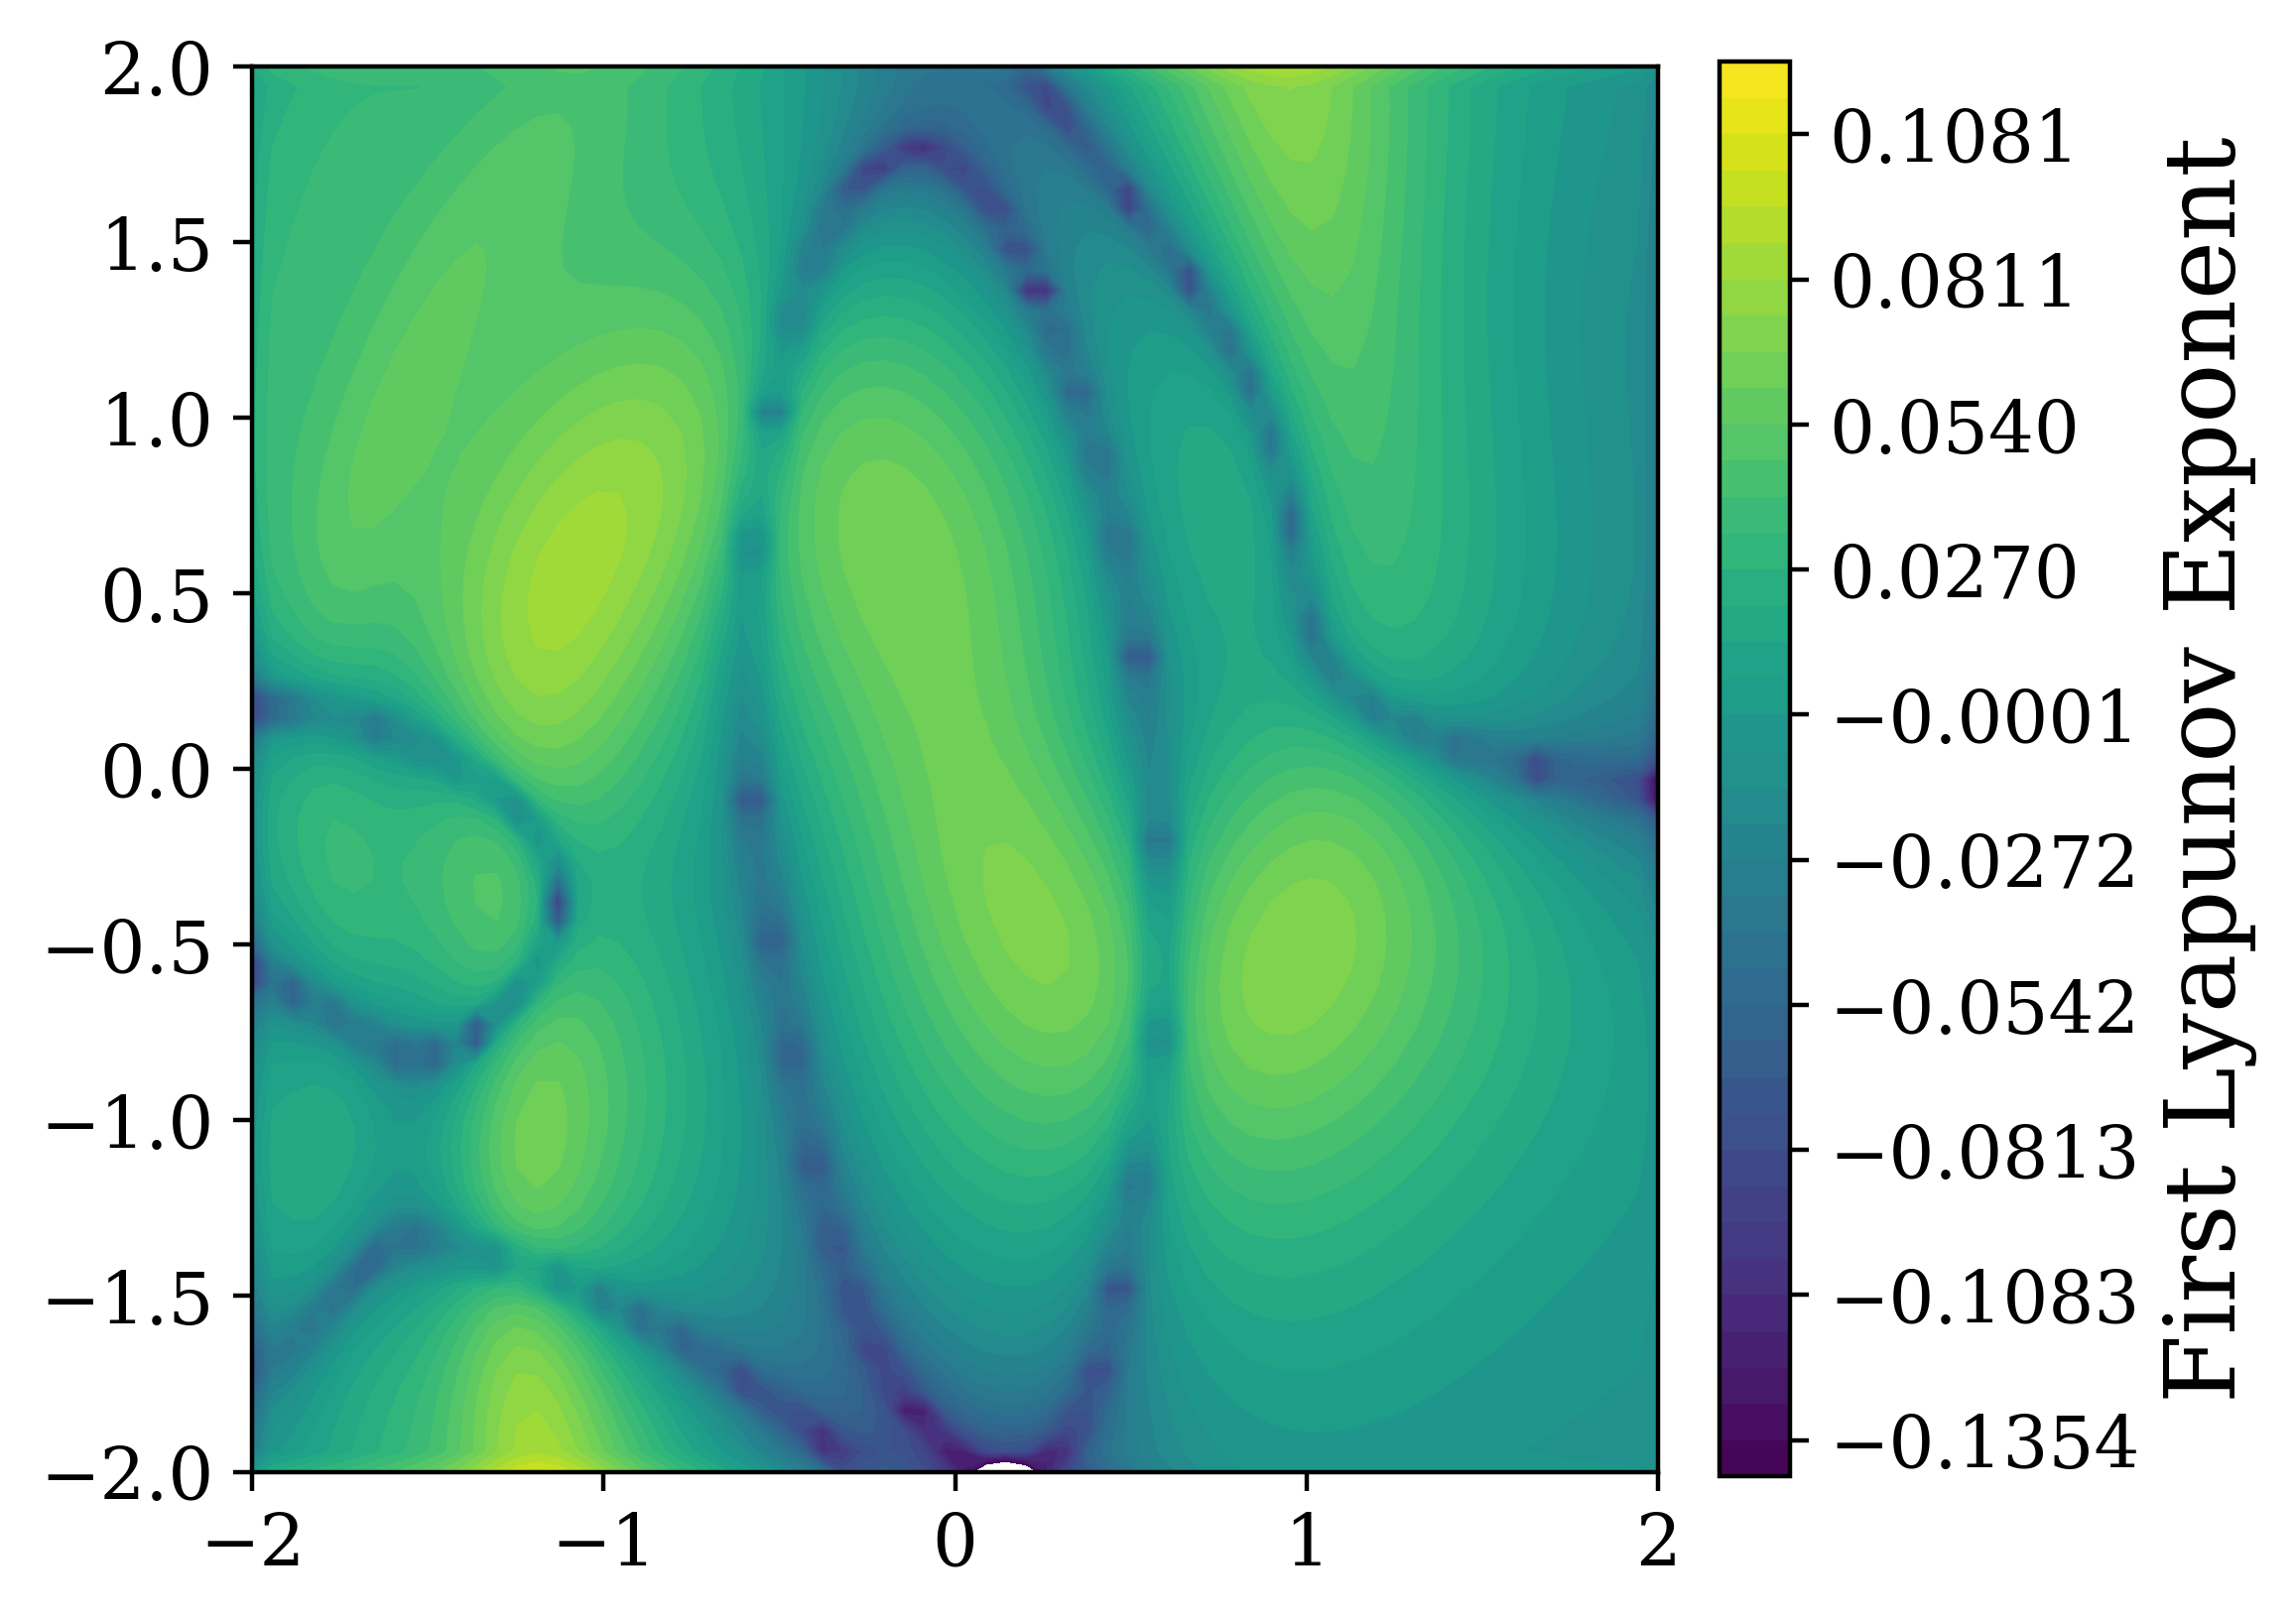

In [43]:
def MLE_test(output, x, y, fig_name=None, footnote=None, contour = True, plotlim = [-1, 1], filename = None):
    
    
    fig = plt.figure(figsize=(5, 5), dpi=100)


    x1lower, x1upper = -2, 2
    x2lower, x2upper = -2, 2

    # model_inputs = torch.stack([x, y], dim=-1)



    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 



    z = np.array(output).reshape(x.shape)

    levels = np.linspace(vmin,vmax,40).tolist()

    cont = plt.contourf(x, y, z, levels, alpha=1, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
    cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('First Lyapunov Exponent')
    if filename:
        plt.savefig(filename + '.png',bbox_inches='tight', dpi=400, format='png', facecolor = 'white')
        plt.close()

x = torch.linspace(-2,2,x_amount)
y = torch.linspace(-2,2,x_amount)
X, Y = torch.meshgrid(x, y)  
    
MLE_test(output, X, Y, filename = 'LE')
MLE_test(routput, X, Y, filename = 'robust_LE')


img_a = Image(filename = 'LE.png', width = 400)
img_b = Image(filename = 'robust_LE.png', width = 400)

display(img_a,img_b)


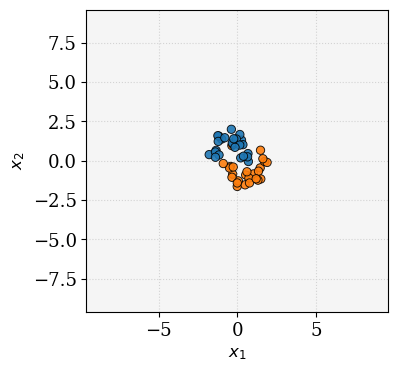

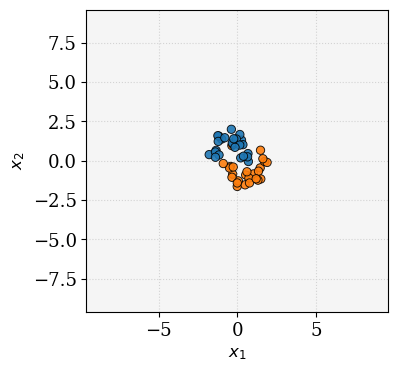

In [22]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif(rnode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

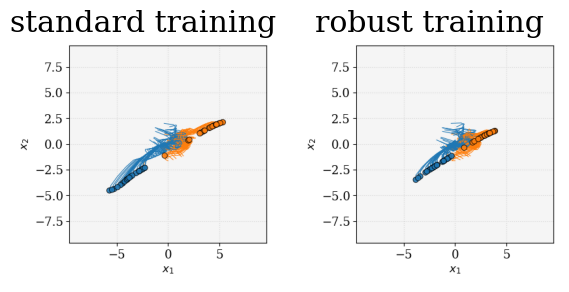

In [23]:
from IPython.display import Image
from plots.plots import comparison_plot
# traj = Image(filename="trajectory19.png", retina = True)
# rtraj = Image(filename="trajectory_db19.png", retina = True)
# display(traj, rtraj)

comparison_plot("trajectory39.png", 'standard training', "trajectory_db39.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

I want to visualize the separation boundary in the final linear layer.

In [24]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from matplotlib.colors import to_rgb
import imageio

from matplotlib.colors import LinearSegmentedColormap
import os


@torch.no_grad()
def linlayer_levelsets(model, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2]):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)

    
   
    model.to(device)

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    preds = model.linear_layer(model_inputs)
    
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 
    
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        levels = np.linspace(0.,1.,20).tolist()
        
        cont = plt.contourf(xx1, xx2, z, levels, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('prediction prob.')
    

    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # else: plt.show()
        

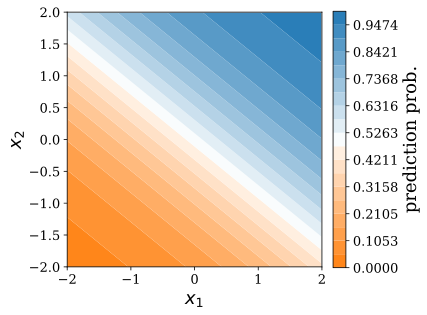

In [25]:
linlayer_levelsets(anode)

In [26]:
@torch.no_grad()
def trajectory_gif_new(model, inputs, targets, timesteps, dpi=200, alpha=0.9,
                   alpha_line=1, filename='trajectory.gif', axlim = 0):
    
    from matplotlib import rc
    from scipy.interpolate import interp1d
    rc("text", usetex = False)
    font = {'size'   : 18}
    rc('font', **font)

    if not filename.endswith(".gif"):
        raise RuntimeError("Name must end in with .gif, but ends with {}".format(filename))
    base_filename = filename[:-4]

    ## We focus on 3 colors at most
    if False in (t < 2 for t in targets): 
        color = ['mediumpurple' if targets[i] == 2.0 else 'gold' if targets[i] == 0.0 else 'mediumseagreen' for i in range(len(targets))]
    else:
        #color = ['crimson' if targets[i, 0] > 0.0 else 'dodgerblue' for i in range(len(targets))]
        color = ['C1' if targets[i] > 0.0 else 'dimgrey' for i in range(len(targets))]

    trajectories = model.flow.trajectory(inputs, timesteps).detach()
    num_dims = trajectories.shape[2]

    if axlim == 0:        
        x_min, x_max = trajectories[:, :, 0].min(), trajectories[:, :, 0].max()
        y_min, y_max = trajectories[:, :, 1].min(), trajectories[:, :, 1].max()
    else: 
        x_min, x_max = -axlim, axlim  #to normalize for rob and standard nODE
        y_min, y_max = -axlim, axlim   #
        
    if num_dims == 3:
        z_min, z_max = trajectories[:, :, 2].min(), trajectories[:, :, 2].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range
    if num_dims == 3:
        z_range = z_max - z_min
        z_min -= margin * z_range
        z_max += margin * z_range
        
    T = model.T 
    integration_time = torch.linspace(0.0, T, timesteps)
    
    interp_x = []
    interp_y = []
    interp_z = []
    for i in range(inputs.shape[0]):
        interp_x.append(interp1d(integration_time, trajectories[:, i, 0], kind='cubic', fill_value='extrapolate'))
        interp_y.append(interp1d(integration_time, trajectories[:, i, 1], kind='cubic', fill_value='extrapolate'))
        if num_dims == 3:
            interp_z.append(interp1d(integration_time, trajectories[:, i, 2], kind='cubic', fill_value='extrapolate'))
    
    interp_time = 20
    # interp_time = 3 #this was 5 before
    _time = torch.linspace(0., T, interp_time)

    plt.rc('grid', linestyle="dotted", color='lightgray')
    for t in range(interp_time):
        if num_dims == 2:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            label_size = 13
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.set_axisbelow(True)
            ax.xaxis.grid(color='lightgray', linestyle='dotted')
            ax.yaxis.grid(color='lightgray', linestyle='dotted')
            ax.set_facecolor('whitesmoke')
            
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.rc('text', usetex=False)
            plt.rc('font', family='serif')
            plt.xlabel(r'$x_1$', fontsize=12)
            plt.ylabel(r'$x_2$', fontsize=12)
            
            x1 = torch.arange(x_min, x_max, step=0.01, device=device)
            x2 = torch.arange(y_min, y_max, step=0.01, device=device)
            xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
            model_inputs = torch.stack([xx1, xx2], dim=-1)
            
            preds = model.linear_layer(model_inputs)
            
            # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
            m = nn.Softmax(dim=2)
            # softmax normalizes the model predictions to probabilities
            preds = m(preds)

            #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
            preds = preds[:, :, 0]
            preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
            
            plt.grid(False)
    

            ax = plt.gca()
            ax.set_aspect('equal') 
            
            
            colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
            cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=40)
            z = np.array(preds).reshape(xx1.shape)
            
            levels = np.linspace(0.,1.,15).tolist()
            
            cont = plt.contourf(xx1, xx2, z, levels, alpha=0.5, cmap=cm, zorder = 0, extent=(x_min, x_max, y_min, y_max)) #plt.get_cmap('coolwarm')
            
            
            
            
            plt.scatter([x(_time)[t] for x in interp_x], 
                         [y(_time)[t] for y in interp_y], 
                         c=color, alpha=alpha, marker = 'o', linewidth=0.65, edgecolors='black', zorder=3)

            if t > 0:
                for i in range(inputs.shape[0]):
                    x_traj = interp_x[i](_time)[:t+1]
                    y_traj = interp_y[i](_time)[:t+1]
                    plt.plot(x_traj, y_traj, c=color[i], alpha=alpha_line, linewidth = 0.75, zorder=1)
            
        
        ax.set_aspect('equal')

        plt.savefig(base_filename + "{}.png".format(t),
                    format='png', dpi=dpi, bbox_inches='tight', facecolor = 'white')
        # Save only 3 frames (.pdf for paper)
        # if t in [0, interp_time//5, interp_time//2, interp_time-1]:
        #     plt.savefig(base_filename + "{}.pdf".format(t), format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

    imgs = []
    for i in range(interp_time):
        img_file = base_filename + "{}.png".format(i)
        imgs.append(imageio.imread(img_file))
        if i not in [0, interp_time//5, interp_time//2, interp_time-1]: os.remove(img_file) 
    imageio.mimwrite(filename, imgs, fps = 2)

In [27]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

data_iter = iter(dataloader)
X,y = next(data_iter)
batch_size = 40

X_viz = torch.zeros_like(X[0:batch_size])
y_viz = torch.zeros(batch_size)
print(y_viz.size())
print(X_viz.size())
X_viz[:,1] = torch.linspace(-5,5,batch_size)
X_viz[:,0] = torch.tensor([0])
print(X_viz)

# plt.scatter(X_viz[:,0],X_viz[:,1])

trajectory_gif_new(anode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
trajectory_gif_new(rnode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)


torch.Size([40])
torch.Size([40, 2])
tensor([[ 0.0000, -5.0000],
        [ 0.0000, -4.7436],
        [ 0.0000, -4.4872],
        [ 0.0000, -4.2308],
        [ 0.0000, -3.9744],
        [ 0.0000, -3.7179],
        [ 0.0000, -3.4615],
        [ 0.0000, -3.2051],
        [ 0.0000, -2.9487],
        [ 0.0000, -2.6923],
        [ 0.0000, -2.4359],
        [ 0.0000, -2.1795],
        [ 0.0000, -1.9231],
        [ 0.0000, -1.6667],
        [ 0.0000, -1.4103],
        [ 0.0000, -1.1538],
        [ 0.0000, -0.8974],
        [ 0.0000, -0.6410],
        [ 0.0000, -0.3846],
        [ 0.0000, -0.1282],
        [ 0.0000,  0.1282],
        [ 0.0000,  0.3846],
        [ 0.0000,  0.6410],
        [ 0.0000,  0.8974],
        [ 0.0000,  1.1538],
        [ 0.0000,  1.4103],
        [ 0.0000,  1.6667],
        [ 0.0000,  1.9231],
        [ 0.0000,  2.1795],
        [ 0.0000,  2.4359],
        [ 0.0000,  2.6923],
        [ 0.0000,  2.9487],
        [ 0.0000,  3.2051],
        [ 0.0000,  3.4615],
        [ 0

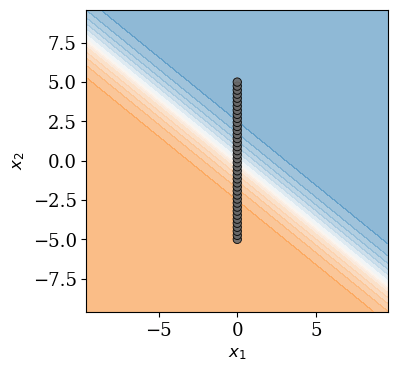

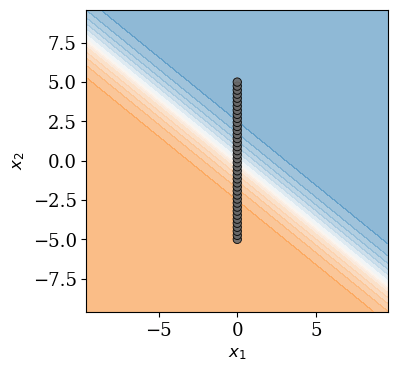

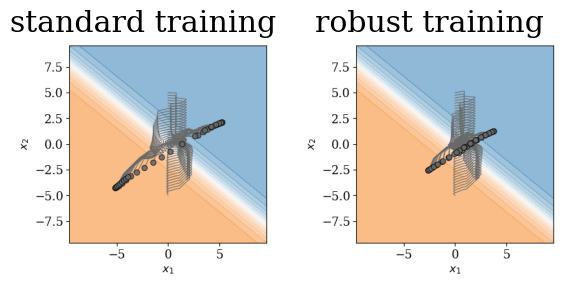

In [28]:
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

In [29]:
for X_viz, y_viz in dataloader_viz:
    trajectory_gif_new(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif_new(rnode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous